# About the dataset


---

The dataset is a real-life event log from a Dutch financial institute. The data containg information about loan processes from 2016 up to February 2nd 2017.

The dataset is part of the 13th International Business Process Intelligence Workshop 2017, and can be found on [this](https://www.win.tue.nl/bpi/doku.php?id=2017:challenge) website.


The data is provided in two files:

**The Application event log**. This event log contains all events with the application as the case ID. Any event related to an offer also refers to an OfferID.

**The Offer event log**. This event log contains all events related to offers, with these offers as case ID. For each offer, a corresponding application is available.

For the purpose of this analysis, only the **application event log** was used.



# Questions

**I - What's the number of events in the applications per month in 2016?**

**II - What's the number of successfull of applications in each month?**

**III - Will the application finish this week?**





# Analyses

**Importing libraries**

In [230]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from google.colab import drive

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

**Loading the application event log**

In [191]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [192]:
application_df = pd.read_csv('/content/drive/My Drive/content/BPI_Challenge_2017.csv')

**Dataset overview**

In [193]:
application_df.head()

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [194]:
application_df.dtypes

Action                    object
org:resource              object
concept:name              object
EventOrigin               object
EventID                   object
lifecycle:transition      object
time:timestamp            object
case:LoanGoal             object
case:ApplicationType      object
case:concept:name         object
case:RequestedAmount     float64
FirstWithdrawalAmount    float64
NumberOfTerms            float64
Accepted                  object
MonthlyCost              float64
Selected                  object
CreditScore              float64
OfferedAmount            float64
OfferID                   object
dtype: object

In [195]:
application_df.describe()

,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,MonthlyCost,CreditScore,OfferedAmount
count,1.202267e+06,42995.000000,42995.000000,42995.000000,42995.000000,42995.000000
mean,1.675947e+04,8394.338979,83.041982,281.403309,318.645912,18513.719940
std,1.572320e+04,10852.443358,36.386199,192.577735,433.706216,13718.507416
min,0.000000e+00,0.000000,5.000000,43.050000,0.000000,5000.000000
25%,6.000000e+03,0.000000,56.000000,152.820000,0.000000,8800.000000
50%,1.400000e+04,5000.000000,77.000000,244.520000,0.000000,15000.000000
75%,2.300000e+04,12000.000000,120.000000,350.000000,848.000000,25000.000000
max,4.500000e+05,75000.000000,180.000000,6673.830000,1145.000000,75000.000000


In [196]:
print(application_df.isnull().sum())
application_df.shape

Action                         0
org:resource                   0
concept:name                   0
EventOrigin                    0
EventID                        0
lifecycle:transition           0
time:timestamp                 0
case:LoanGoal                  0
case:ApplicationType           0
case:concept:name              0
case:RequestedAmount           0
FirstWithdrawalAmount    1159272
NumberOfTerms            1159272
Accepted                 1159272
MonthlyCost              1159272
Selected                 1159272
CreditScore              1159272
OfferedAmount            1159272
OfferID                  1051413
dtype: int64


(1202267, 19)

**Editing column with the event timestamp**

In [197]:
application_df['datetime'] = pd.to_datetime(application_df['time:timestamp'])
application_df.dtypes

Action                                object
org:resource                          object
concept:name                          object
EventOrigin                           object
EventID                               object
lifecycle:transition                  object
time:timestamp                        object
case:LoanGoal                         object
case:ApplicationType                  object
case:concept:name                     object
case:RequestedAmount                 float64
FirstWithdrawalAmount                float64
NumberOfTerms                        float64
Accepted                              object
MonthlyCost                          float64
Selected                              object
CreditScore                          float64
OfferedAmount                        float64
OfferID                               object
datetime                 datetime64[ns, UTC]
dtype: object

**Creating columns with the week of the year**

In [198]:
application_df['week_of_year'] = application_df['datetime'].dt.strftime('%G%V')
application_df['week'] = (application_df['datetime'].apply(lambda x: x - timedelta(x.dayofweek))).dt.date
application_df.head()

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,datetime,week_of_year,week
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.304000+00:00,201553,2015-12-28
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.352000+00:00,201553,2015-12-28
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.774000+00:00,201553,2015-12-28
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:52:36.392000+00:00,201553,2015-12-28
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:52:36.403000+00:00,201553,2015-12-28


**What's the number of events in the applications per month in 2016?**

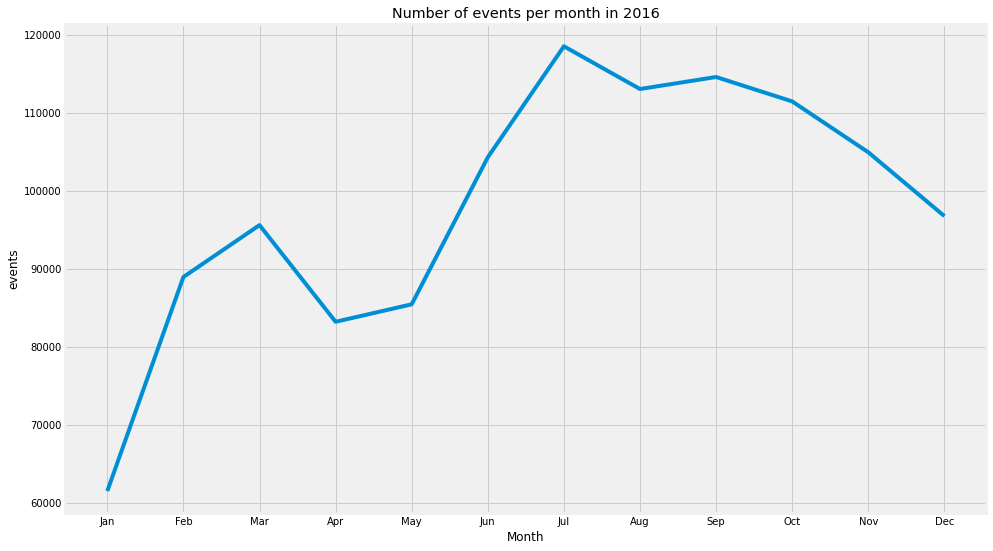

In [199]:
copy_df = application_df[application_df['datetime'].dt.year == 2016]

plt.figure(figsize=(14.7, 9))
chart = copy_df.groupby(copy_df['datetime'].dt.month)['datetime'].count().plot(kind='line')
chart.set(xlabel='Month', ylabel='events', title='Number of events per month in 2016')

months = [calendar.month_abbr[i] for i in range(1, 13)]

plt.xticks(np.arange(1, 13, 1.0), labels=months)
plt.show()


During 2016, July was the month with the higher number of events in comparision to the other months of the same year.

 We can also observe that there is a trend in the increase of number of events starting in January and ending in March, and another increase in the number of events starting in April and reaching the higher number of events during the entire year in July.

**What's the number of successfull of applications in each month?**

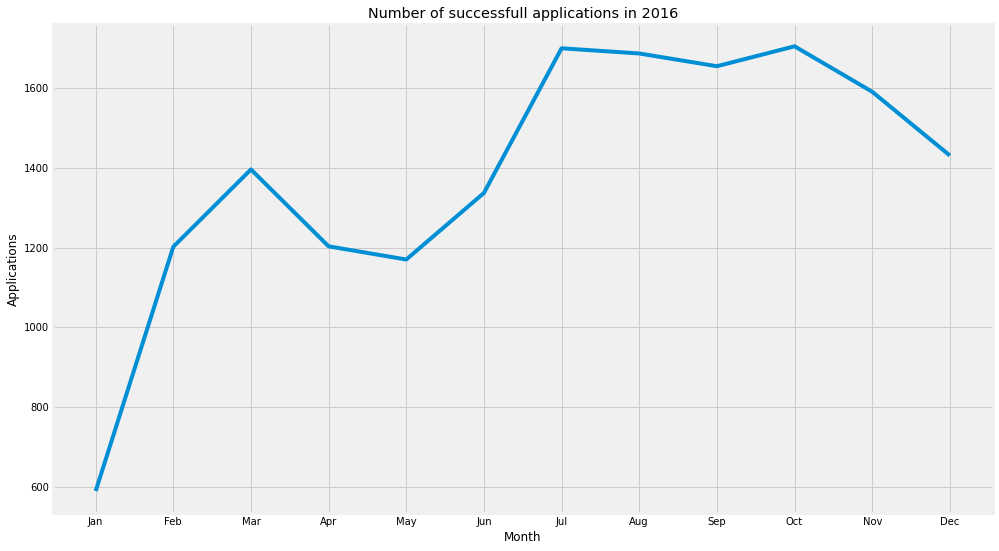

In [200]:
copy_df = application_df[(application_df['concept:name'] == 'A_Pending')
 & (application_df['datetime'].dt.year == 2016)]

plt.figure(figsize=(15, 9))
chart = copy_df.groupby(copy_df['datetime'].dt.month)['concept:name'].count().plot(kind='line')
chart.set(xlabel='Month', ylabel='Applications', title='Number of successfull applications in 2016')

plt.xticks(np.arange(1, 13, 1.0), labels=months)
plt.show()

It's expected that tha month that has the higher number of events is also the month with more successfull applications.

An interesting point is that in Octber there also a high number of successfull applications, very similar to tu number observed in July.

**What are the top 5 most actives week in the applications?**

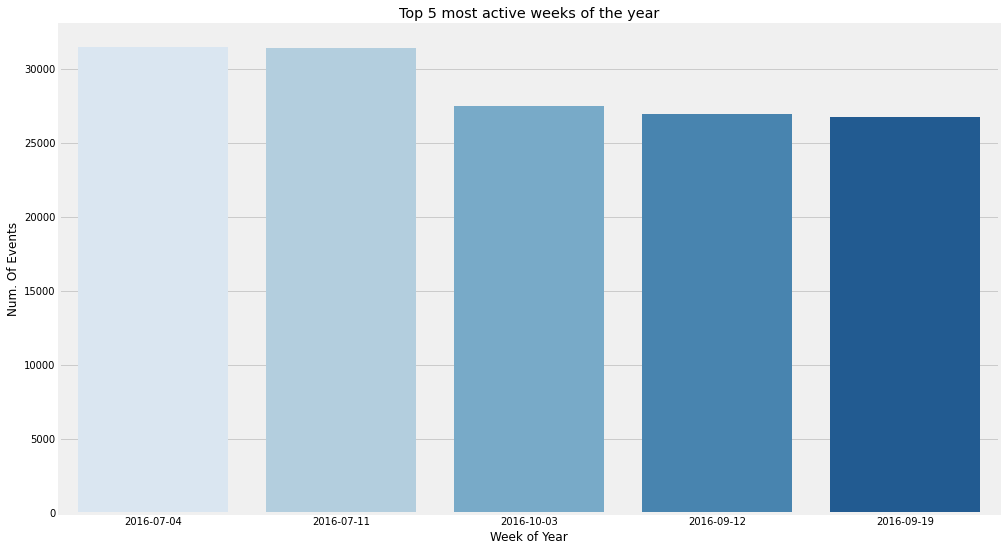

In [201]:
plt.figure(figsize=(15, 9))

most_actives_weeks = application_df['week'].value_counts().head(5).reset_index()
most_actives_weeks.rename(columns={'index': 'week', 'week':'num_of_events'}, inplace=True)

chart = sns.barplot(data = most_actives_weeks, x ='week', y= 'num_of_events', palette = "Blues");
chart.set(xlabel = 'Week of Year', ylabel ='Num. Of Events', title='Top 5 most active weeks of the year')

plt.show()

The top two weeks with more activities were the first two weeks of July, followed by the first week of October than the second and third weeks of September.

# Predictive Analysis

###Feature Creation

**Getting the applications start date**

In [202]:
apps_start_date = application_df[(application_df['concept:name'] == 'A_Create Application')].filter([
    'case:concept:name', 'datetime', 'week'])

apps_start_date.rename(columns={'datetime': 'start_date', 'week': 'start_week'}, inplace=True)
apps_start_date.head()

,case:concept:name,start_date,start_week
0,Application_652823628,2016-01-01 09:51:15.304000+00:00,2015-12-28
40,Application_1691306052,2016-01-01 10:16:11.500000+00:00,2015-12-28
71,Application_428409768,2016-01-01 11:19:38.177000+00:00,2015-12-28
116,Application_1746793196,2016-01-01 12:34:53.911000+00:00,2015-12-28
200,Application_828200680,2016-01-01 13:00:04.360000+00:00,2015-12-28


**Getting the applications end date**

In [203]:
apps_final_states = ['A_Pending', 'A_Cancelled', 'A_Denied']
apps_end_date = application_df[(application_df['concept:name'].isin(
    apps_final_states))].filter(['case:concept:name', 'datetime', 'week'])

apps_end_date.rename(columns={'datetime': 'end_date', 'week': 'end_week'}, inplace=True)
apps_end_date.drop_duplicates(subset='case:concept:name', inplace=True)
apps_end_date.head()

,case:concept:name,end_date,end_week
38,Application_652823628,2016-01-14 15:49:11.420000+00:00,2016-01-11
68,Application_1691306052,2016-01-07 13:29:49.671000+00:00,2016-01-04
114,Application_428409768,2016-01-14 07:00:14.450000+00:00,2016-01-11
197,Application_1746793196,2016-01-28 12:18:51.292000+00:00,2016-01-25
218,Application_828200680,2016-02-02 07:00:20.734000+00:00,2016-02-01


**Merging the start date and end date DataFrames**

In [204]:
apps_df = pd.merge(apps_start_date, apps_end_date, how='inner')
apps_df['duration'] = (apps_df['end_date'] - apps_df['start_date']).dt.days

apps_df.head()

,case:concept:name,start_date,start_week,end_date,end_week,duration
0,Application_652823628,2016-01-01 09:51:15.304000+00:00,2015-12-28,2016-01-14 15:49:11.420000+00:00,2016-01-11,13
1,Application_1691306052,2016-01-01 10:16:11.500000+00:00,2015-12-28,2016-01-07 13:29:49.671000+00:00,2016-01-04,6
2,Application_428409768,2016-01-01 11:19:38.177000+00:00,2015-12-28,2016-01-14 07:00:14.450000+00:00,2016-01-11,12
3,Application_1746793196,2016-01-01 12:34:53.911000+00:00,2015-12-28,2016-01-28 12:18:51.292000+00:00,2016-01-25,26
4,Application_828200680,2016-01-01 13:00:04.360000+00:00,2015-12-28,2016-02-02 07:00:20.734000+00:00,2016-02-01,31


**Checking the application's duration distribution**

In [205]:
apps_df.describe()

,duration
count,31411.000000
mean,21.255452
std,12.897043
min,0.000000
25%,11.000000
50%,19.000000
75%,31.000000
max,169.000000


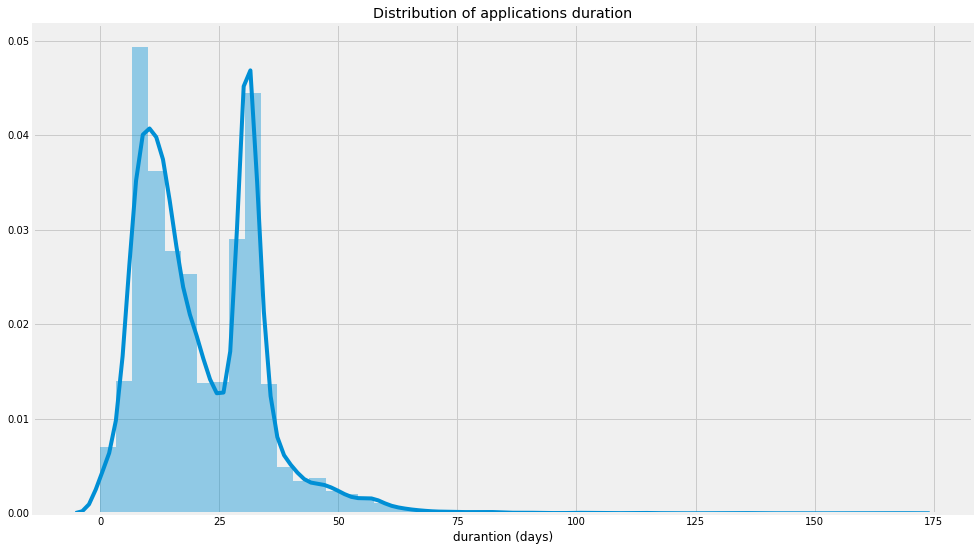

In [206]:
plt.figure(figsize=(15, 9))

ax = sns.distplot(apps_df['duration'])
ax.set(xlabel='durantion (days)', title='Distribution of applications duration')

plt.show()

**Adding "has finished this week" column**

In [207]:
apps_end_week = apps_df[['case:concept:name', 'end_week']]

application_df = pd.merge(application_df, apps_end_week, on=['case:concept:name'])
application_df['finished_this_week'] = application_df['week'] == application_df['end_week'] 

**Adding "quarter" column**

In [208]:
application_df['quarter'] = application_df['datetime'].dt.quarter

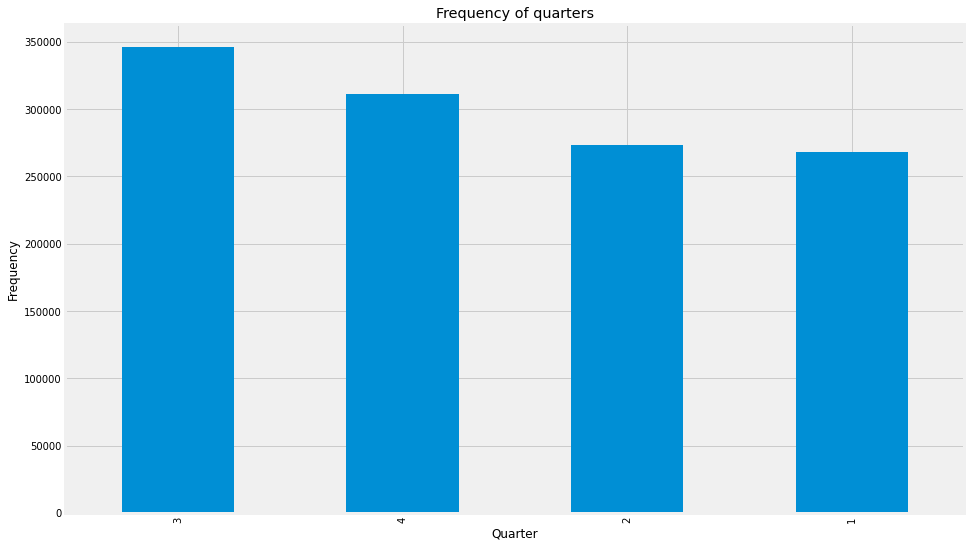

In [209]:
plt.figure(figsize=(14.35, 9))
chart = application_df['quarter'].value_counts().plot(kind='bar')
chart.set(xlabel='Quarter', ylabel='Frequency', title='Frequency of quarters')

plt.show()

**Checking the events of a specific application**

In [210]:
application_df[application_df['case:concept:name'] == 'Application_652823628']

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,datetime,week_of_year,week,end_week,finished_this_week,quarter
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.304000+00:00,201553,2015-12-28,2016-01-11,False,1
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.352000+00:00,201553,2015-12-28,2016-01-11,False,1
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.774000+00:00,201553,2015-12-28,2016-01-11,False,1
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:52:36.392000+00:00,201553,2015-12-28,2016-01-11,False,1
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:52:36.403000+00:00,201553,2015-12-28,2016-01-11,False,1
5,statechange,User_1,A_Concept,Application,ApplState_642383566,complete,2016-01-01 09:52:36.413000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:52:36.413000+00:00,201553,2015-12-28,2016-01-11,False,1
6,Obtained,User_17,W_Complete application,Workflow,Workitem_1875340971,start,2016-01-02 10:45:22.429000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-02 10:45:22.429000+00:00,201553,2015-12-28,2016-01-11,False,1
7,Released,User_17,W_Complete application,Workflow,Workitem_1452291795,suspend,2016-01-02 10:49:28.816000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-02 10:49:28.816000+00:00,201553,2015-12-28,2016-01-11,False,1
8,statechange,User_52,A_Accepted,Application,ApplState_99568828,complete,2016-01-02 11:23:04.299000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-02 11:23:04.299000+00:00,201553,2015-12-28,2016-01-11,False,1
9,Created,User_52,O_Create Offer,Offer,Offer_148581083,complete,2016-01-02 11:29:03.994000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,20000.0,44.0,True,498.29,True,979.0,20000.0,NaN,2016-01-02 11:29:03.994000+00:00,201553,2015-12-28,2016-01-11,False,1


**Creating column with events cumulative sum**

In [211]:
events_per_week_df = application_df[application_df['EventOrigin'] == 'Application'].rename(columns={'case:concept:name':'application_id'})
events_per_week_df = events_per_week_df.groupby(['application_id', 'week_of_year'])['EventOrigin'].count().reset_index().rename(columns={'EventOrigin':'num_events'})
events_per_week_df['ac_events'] = events_per_week_df.groupby(['application_id'])['num_events'].apply(lambda x: x.cumsum())
events_per_week_df

,application_id,week_of_year,num_events,ac_events
0,Application_1000086665,201631,5,5
1,Application_1000086665,201636,1,6
2,Application_1000158214,201622,3,3
3,Application_1000158214,201623,4,7
4,Application_1000311556,201614,4,4
...,...,...,...,...
84903,Application_999993467,201629,1,6
84904,Application_999993812,201640,3,3
84905,Application_999993812,201641,2,5
84906,Application_999993812,201642,2,7


**Creating dataset to be used in predictive analysis**

In [212]:
app_temp_df = application_df[application_df['EventOrigin'] == 'Application'].filter(['case:concept:name', 'case:LoanGoal', 'case:RequestedAmount', 'week', 'finished_this_week', 'week_of_year', 'quarter']).copy(
    deep=True).rename(columns={'case:concept:name': 'application_id', 'case:LoanGoal': 'LoanGoal', 'case:RequestedAmount': 'RequestedAmount'})

app_temp_df

,application_id,LoanGoal,RequestedAmount,week,finished_this_week,week_of_year,quarter
0,Application_652823628,Existing loan takeover,20000.0,2015-12-28,False,201553,1
1,Application_652823628,Existing loan takeover,20000.0,2015-12-28,False,201553,1
5,Application_652823628,Existing loan takeover,20000.0,2015-12-28,False,201553,1
8,Application_652823628,Existing loan takeover,20000.0,2015-12-28,False,201553,1
15,Application_652823628,Existing loan takeover,20000.0,2015-12-28,False,201553,1
...,...,...,...,...,...,...,...
1198299,Application_1350494635,Home improvement,20000.0,2016-12-26,False,201652,4
1198303,Application_1350494635,Home improvement,20000.0,2016-12-26,False,201652,4
1198305,Application_1350494635,Home improvement,20000.0,2017-01-02,False,201701,1
1198312,Application_1350494635,Home improvement,20000.0,2017-01-02,False,201701,1


**Checking for missing values**

In [213]:
app_temp_df.isnull().sum()

application_id        0
LoanGoal              0
RequestedAmount       0
week                  0
finished_this_week    0
week_of_year          0
quarter               0
dtype: int64

**Removing duplicates**

In [214]:
app_temp_df = app_temp_df.drop_duplicates().reset_index(drop=True)

**Mergin with cum sum events df**

In [215]:
app_temp_df = pd.merge(app_temp_df, events_per_week_df, on=[
                       'application_id', 'week_of_year'])

**Editing dataframe to be used in preditcion**

In [216]:
temporal_df = app_temp_df.copy(deep=True)
temporal_df.drop(['LoanGoal', 'week', 'quarter'], axis=1, inplace=True)

temporal_df.drop_duplicates(inplace=True)
temporal_df

,application_id,RequestedAmount,finished_this_week,week_of_year,num_events,ac_events
0,Application_652823628,20000.0,False,201553,5,5
1,Application_652823628,20000.0,True,201602,4,9
2,Application_1691306052,10000.0,False,201553,5,5
3,Application_1691306052,10000.0,True,201601,2,7
4,Application_428409768,15000.0,False,201553,5,5
...,...,...,...,...,...,...
85461,Application_303923658,30000.0,False,201703,3,8
85462,Application_303923658,30000.0,True,201704,3,11
85463,Application_1350494635,20000.0,False,201652,3,3
85464,Application_1350494635,20000.0,False,201701,2,5


**Splitting data in train and test (70/30)**

In [217]:
X_train, X_test = train_test_split(temporal_df['application_id'].drop_duplicates(), test_size=0.3)
X_train = temporal_df.merge(X_train, on="application_id")
X_test = temporal_df.merge(X_test, on="application_id")

y_test = X_test['finished_this_week']
y_train = X_train['finished_this_week']


**Checking if the same application isn't in both train and test sets**

In [218]:
apps_id_test = X_test['application_id'].unique()
apps_id_train = X_train['application_id'].unique()

assert np.intersect1d(apps_id_test, apps_id_train).size == 0

**Removind uneeded columns**

In [219]:
X_train.drop(['application_id', 'finished_this_week'], axis=1, inplace=True)
X_test.drop(['application_id', 'finished_this_week'], axis=1, inplace=True)

### Classifiers

Creating auxiliary function to get the acurracy of the models

In [220]:
def get_model_accuracy(clf_name, clf):
    training_accry = clf.score(X_train, y_train)
    test_accry = clf.score(X_test, y_test)

    clf_str = 'Acurracy of {} classifer on'.format(clf_name)
    model_acurracy_str = '{} {} set {:.2f}\n{} {} set {:.2f}'.format(
        clf_str, 'training', training_accry, clf_str, 'test', test_accry)

    return model_acurracy_str

**Logistic Regression**

In [221]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

print(get_model_accuracy('Logistic Regression', logreg))

Acurracy of Logistic Regression classifer on training set 0.63
Acurracy of Logistic Regression classifer on test set 0.63


**Decision Tree**

In [222]:
clf = DecisionTreeClassifier().fit(X_train, y_train)

print(get_model_accuracy('Decision Tree', clf))

Acurracy of Decision Tree classifer on training set 0.91
Acurracy of Decision Tree classifer on test set 0.79


**K-Nearest Neighbors**

In [223]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

print(get_model_accuracy('K-NN', knn))

Acurracy of K-NN classifer on training set 0.84
Acurracy of K-NN classifer on test set 0.78


**Linear Discriminant Analysis**

In [224]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

print(get_model_accuracy('LDA', lda))

Acurracy of LDA classifer on training set 0.79
Acurracy of LDA classifer on test set 0.79


**Gaussian Naive Bayes**

In [225]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

print(get_model_accuracy('GNB', gnb))

Acurracy of GNB classifer on training set 0.76
Acurracy of GNB classifer on test set 0.76


**Random Forest**

In [226]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print(get_model_accuracy('Random Forest', clf))

Acurracy of Random Forest classifer on training set 0.91
Acurracy of Random Forest classifer on test set 0.80


The random forest was the classifier with the better results in both training and test sets in comparision to the others used during this stage.

###Model evaluation

**After running the classifiers, the Random Forest Classifier had a good result in both training and test set, thus it was used for the evaluation using some performance metrics**



*   **Accuracy:** the ratio of correctly predicted observation to the total observations
*   **Precision:** proportion of positive identifications that was actually correct
*   **Recall**: proportion of actual positives that was identified correctly
* **F1 Score:** weighted average of Precision and Recall





In [227]:
accuracy = metrics.accuracy_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

print('Accuracy: ', accuracy)
print('Recall: ', recall)
print('Precision: ', precision)
print('F1 Score: ', f1_score)

Accuracy:  0.799639413655248
Recall:  0.7731324278438031
Precision:  0.7101364522417154
F1 Score:  0.7402966876651088


To evaluate the effectiveness of the model it's important to look not only for the acurracy, but also the Recall, Precision and F1 Score metrics.

Recall and precision are often in tension, in other words, improving one reduces another and vice versa. So that it's importante to also calculate the F1 Score to seek a balance between precision and recall.

**Confusion Matrix**

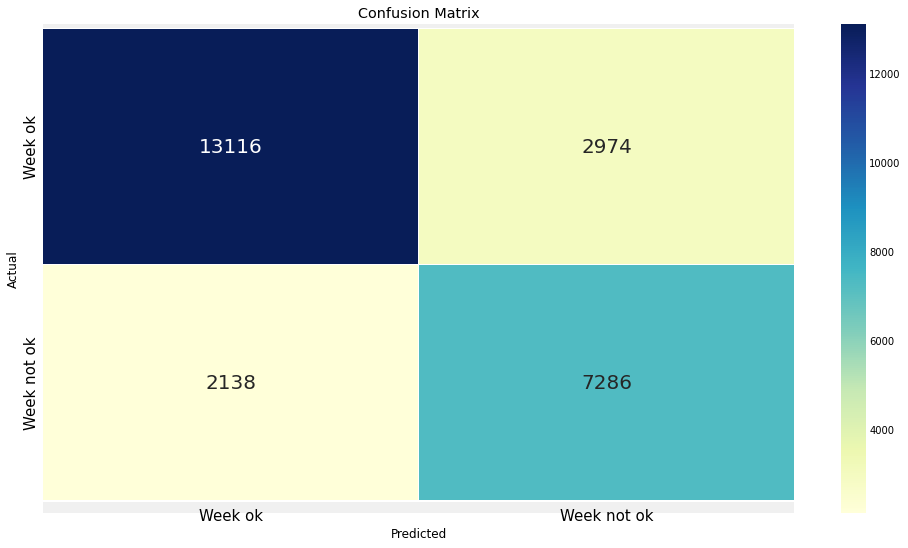

In [228]:
plt.figure(figsize=(15, 9))

ax = (sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, annot_kws={"size": 20}, 
                 linewidths=.1, fmt='d', cmap='YlGnBu'))
plt.yticks([0.5,1.5,2], [ 'Week ok', 'Week not ok'], va='center', fontsize=15)
plt.xticks([0.5,1.5,2], [ 'Week ok', 'Week not ok'], va='center', fontsize=15)
ax.set_title("Confusion Matrix")
ax.set(xlabel="Predicted", ylabel="Actual")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.05, top - 0.02)

plt.show()

**Features Importances**

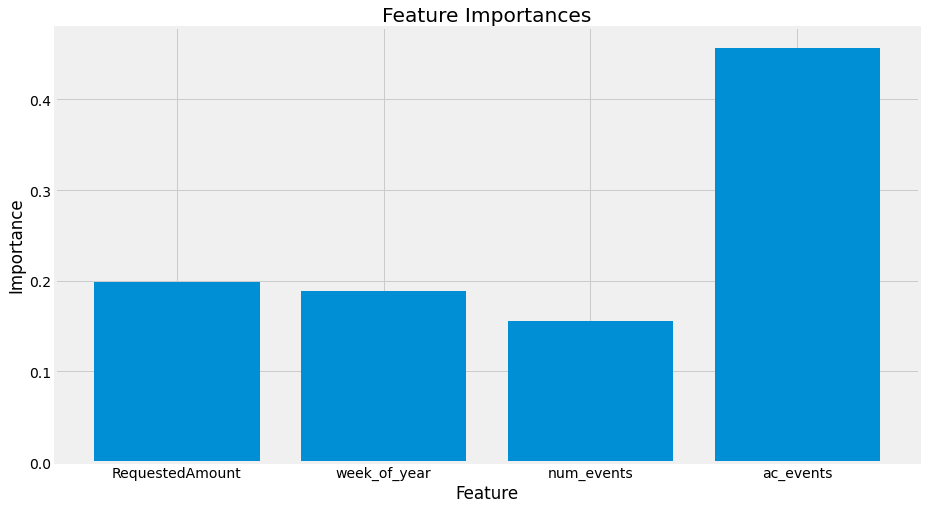

In [229]:
feature_list = X_train.columns
feature_imp = pd.Series(clf.feature_importances_, index = feature_list)

plt.figure(figsize=(13.8, 8))
plt.style.use('fivethirtyeight')

x_values = list(range(len(feature_imp)))
plt.bar(x_values, feature_imp, orientation = 'vertical')
plt.xticks(x_values, feature_list)
plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Feature Importances')

plt.show()

The cumalative sum of events per application was the most important feature in the model, one explanation is that the higher the number of events the higher the chance that the application will end that week, because there is some events that must happend before an application gets to the final stage.

#Conclusions

In this notebook, we explored data of a real-life event log from a Dutch financial institute with the objective to practice data science and to find insights and acquire knowledge.

We analyzed the applications activities per month and week, observing the more frequent ones and their distribution.

Then, we built a classification model using Random Forest to predicte if the application will finish in the current week. Our model had an acurracy of 80% in our tests.

The results were good for the initial pourpose, but it's still possible to improve our model by trying new combinantions of features, improving the data split, trying diffrent paramaters in the classifers among others.